This workflow shown in this notebook is inspired by the following ressources:
- https://medium.com/swlh/facebook-prophet-426421f7e331
- https://medium.com/analytics-vidhya/time-series-tutorial-using-neuralprophet-e918a1b437ed
- https://medium.com/dropout-analytics/cross-validating-prophet-at-scale-72b1a21b6433
- https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66
- https://www.superdatascience.com/courses/data-science-for-business-case-studies/

# PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img 
        src="images/fig_1.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Future Sales Time-series Prediction (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_2.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2. Problem Statement (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>


<table>
  <tr><td>
    <img 
        src="images/fig_3.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3. Problem Statement (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_4.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 4. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_5.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 5. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

<table>
  <tr><td>
    <img 
        src="images/fig_6.jpg"
        alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 6. Inputs and Outputs (with courtesy of: www.superdatascience.com) 
  </td></tr>
</table>

# IMPORT LIBRARIES AND DATASET 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# You have to include the full link to the csv file containing your dataset
sales_train_df = pd.read_csv('data/train.csv')

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
sales_train_df.head(5)
# almost a million observation 
# 1115 unique stores 
# Note that sales is the target variable (that's what we are trying to predict) 

# Id: transaction ID (combination of Store and date) 
# Store: unique store Id
# Sales: sales/day, this is the target variable 
# Customers: number of customers on a given day
# Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
# Promo: describes if store is running a promo on that day or not
# StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
# SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

#- Data Source: https://www.kaggle.com/c/rossmann-store-sales/data



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
# lets check out how many stores we have
print('we identify {} different stores in the dataset!'.format(len(sales_train_df['Store'].unique())))

we identify 1115 different stores in the dataset!


In [6]:
# How many observations do we have per store?
sales_train_df[['Store', 'Sales']].groupby(by='Store').count()

,Sales
Store,
1,942
2,942
3,942
4,942
5,942
...,...
1111,942
1112,942
1113,942


In [7]:
# let´s check out the time series of store #1
sales_train_df[sales_train_df['Store']==1].sort_values(by='Date')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1
...,...,...,...,...,...,...,...,...,...
4460,1,1,2015-07-27,6102,612,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1


In [8]:
sales_train_df.info()
# 9 columns in total 
# 8 features, each contains 1017209 data points
# 1 target variable (sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [9]:
sales_train_df.describe()
# Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
# Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
store_info_df = pd.read_csv('data/store.csv')

# StoreType: categorical variable to indicate type of store (a, b, c, d)
# Assortment: describes an assortment level: a = basic, b = extra, c = extended
# CompetitionDistance (meters): distance to closest competitor store
# CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
# Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
# Promo2Since [Year/Week]: date when the store started participating in Promo2
# PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store




In [11]:
store_info_df.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# Let's do the same for the store_info_df data
# Note that the previous dataframe includes the transactions recorded per day (in millions)
# This dataframe only includes information about the unique 1115 stores that are part of this study 
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
store_info_df.describe()
# on average, the competition distance is 5404 meters away (5.4 kms)

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# EXPLORE DATASET

## Explore Dataset 1: Sales Data

<AxesSubplot:>

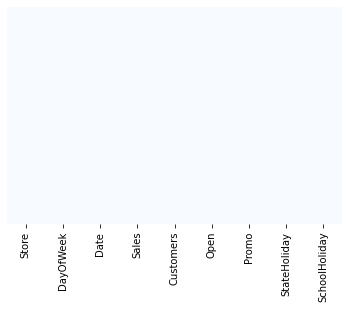

In [14]:
# Let's see if we have any missing data, luckily we don't!
# sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
sns.heatmap(sales_train_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Sales'}>],
       [<AxesSubplot:title={'center':'Customers'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Promo'}>],
       [<AxesSubplot:title={'center':'SchoolHoliday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

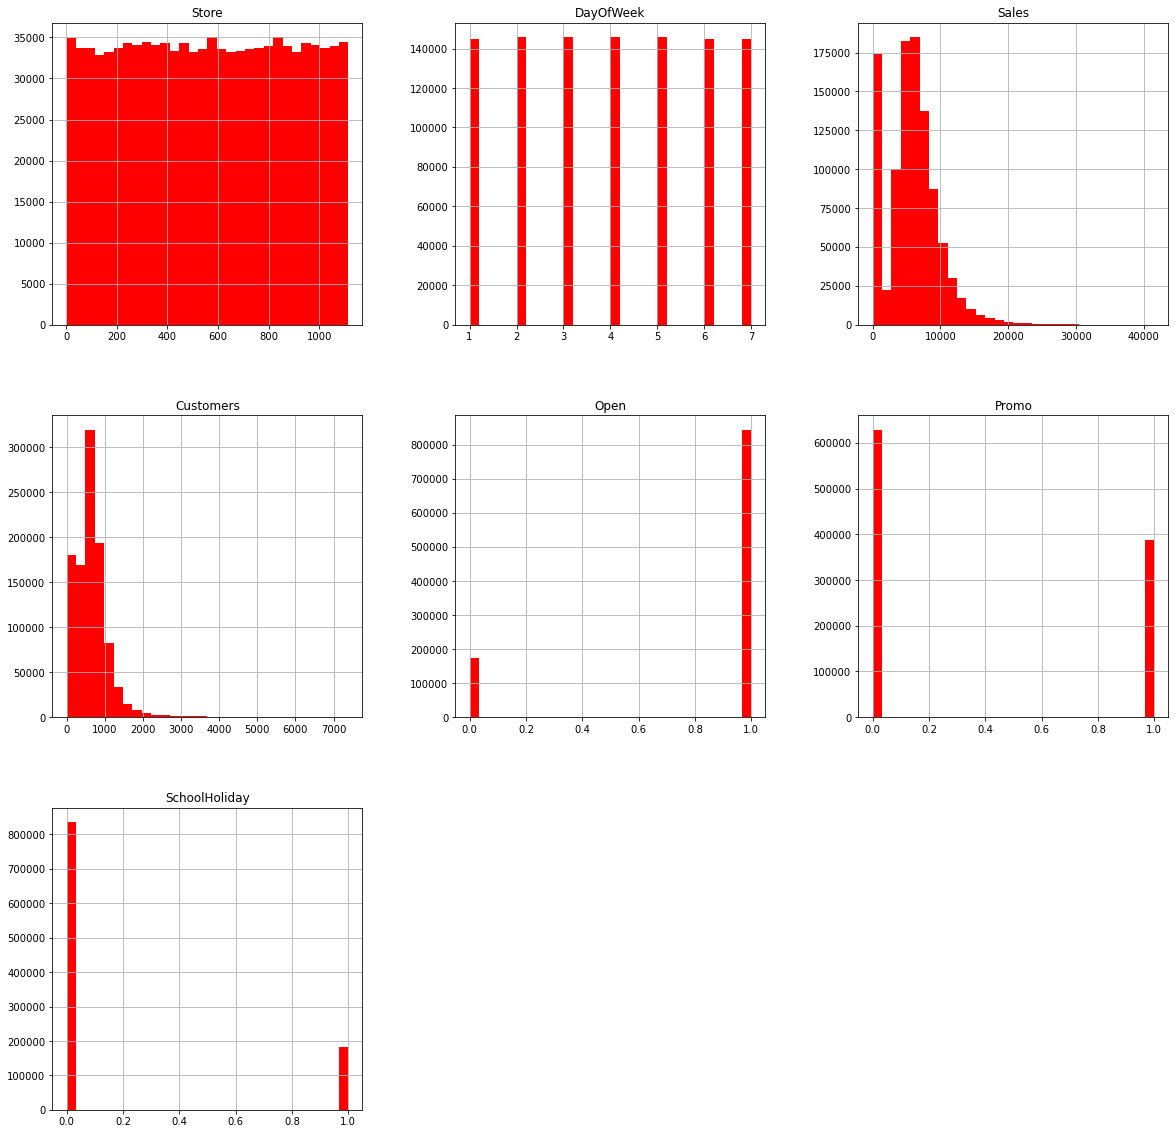

In [15]:
sales_train_df.hist(bins = 30, figsize = (20,20), color = 'r')
# Average 600 customers per day, maximum is 4500 (note that we can't see the outlier at 7388!)
# Data is equally distibuted across various Days of the week (~150000 observations x 7 day = ~1.1 million observation) 
# Stores are open ~80% of the time
# Data is equally distributed among all stores (no bias)
# Promo #1 was running ~40% of the time 
# Average sales around 5000-6000 Euros
# School holidays are around ~18% of the time



In [16]:
sales_train_df['Customers'].max()

7388

In [17]:
# Let's see how many stores are open and closed! 
closed_train_df        = sales_train_df[sales_train_df['Open'] == 0]
open_train_df          = sales_train_df[sales_train_df['Open'] == 1]


In [18]:
# Count the number of stores that are open and closed
print("Total =", len(sales_train_df))
print("Number of closed stores =", len(closed_train_df))
print("Number of open stores =", len(open_train_df))

Total = 1017209
Number of closed stores = 172817
Number of open stores = 844392


In [19]:
# only keep open stores and remove closed stores
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [20]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [21]:
# Let's drop the open column since it has no meaning now
sales_train_df.drop(['Open'], axis=1, inplace=True)

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [23]:
sales_train_df.describe()
# Average sales = 6955 Euros,	average number of customers = 762	(went up)

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


## Explore Dataset 2: Store Information

In [24]:
store_info_df.isnull()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,False,False,False,False,False,False,False,True,True,True
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,True,True
4,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
1110,False,False,False,False,False,False,False,False,False,False
1111,False,False,False,False,False,False,False,True,True,True
1112,False,False,False,False,True,True,False,True,True,True
1113,False,False,False,False,True,True,False,True,True,True


<AxesSubplot:>

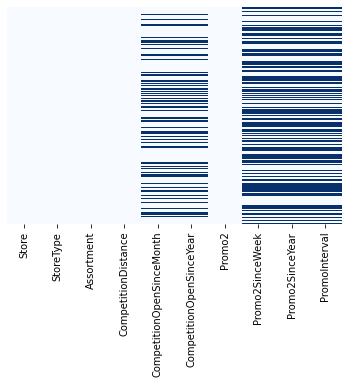

In [25]:
# Let's see if we have any missing data in the store information dataframe!
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [26]:
# Let's take a look at the missing values in the 'CompetitionDistance'
# Only 3 rows are missing 
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [27]:
# Let's take a look at the missing values in the 'CompetitionOpenSinceMonth'
# many rows are missing = 354 (almost one third of the 1115 stores)
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [28]:
store_info_df[ store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [29]:
# It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to zero
# There are 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing
# Let's set these values to zeros 
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in str_cols:
    store_info_df [str].fillna(0, inplace = True)

<AxesSubplot:>

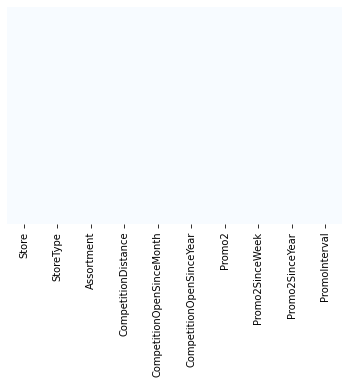

In [30]:
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")


In [31]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

<AxesSubplot:>

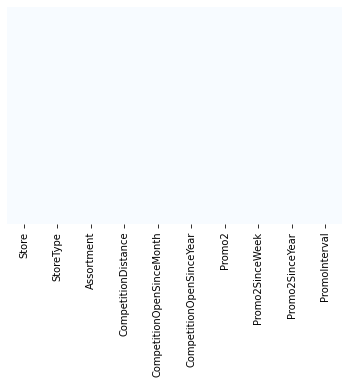

In [32]:
sns.heatmap(store_info_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'CompetitionDistance'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceMonth'}>],
       [<AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>,
        <AxesSubplot:title={'center':'Promo2SinceWeek'}>],
       [<AxesSubplot:title={'center':'Promo2SinceYear'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

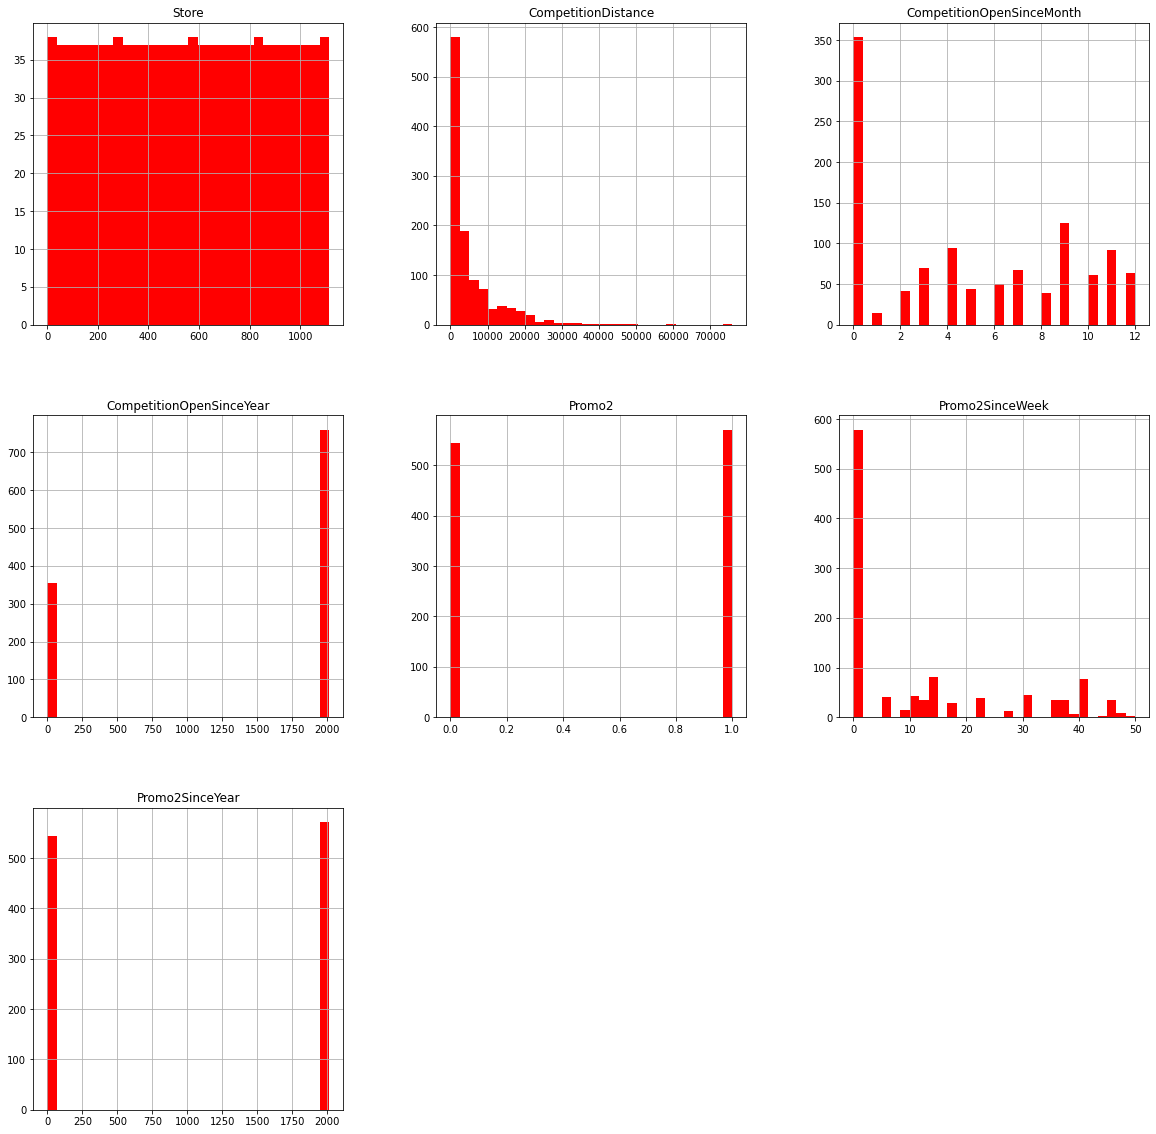

In [33]:
store_info_df.hist(bins = 30, figsize = (20,20), color = 'r')
# half of stores are involved in promo 2
# half of the stores have their competition at a distance of 0-3000m (3 kms away)

## Explore Merged Dataset 

In [34]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [35]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [36]:
# Let's merge both data frames together based on 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store') 

In [37]:
sales_train_all_df.to_csv('data/test.csv', index=False)

In [38]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [39]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

In [40]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

# customers and promo are positively correlated with the sales 
# Promo2 does not seem to be effective at all 

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

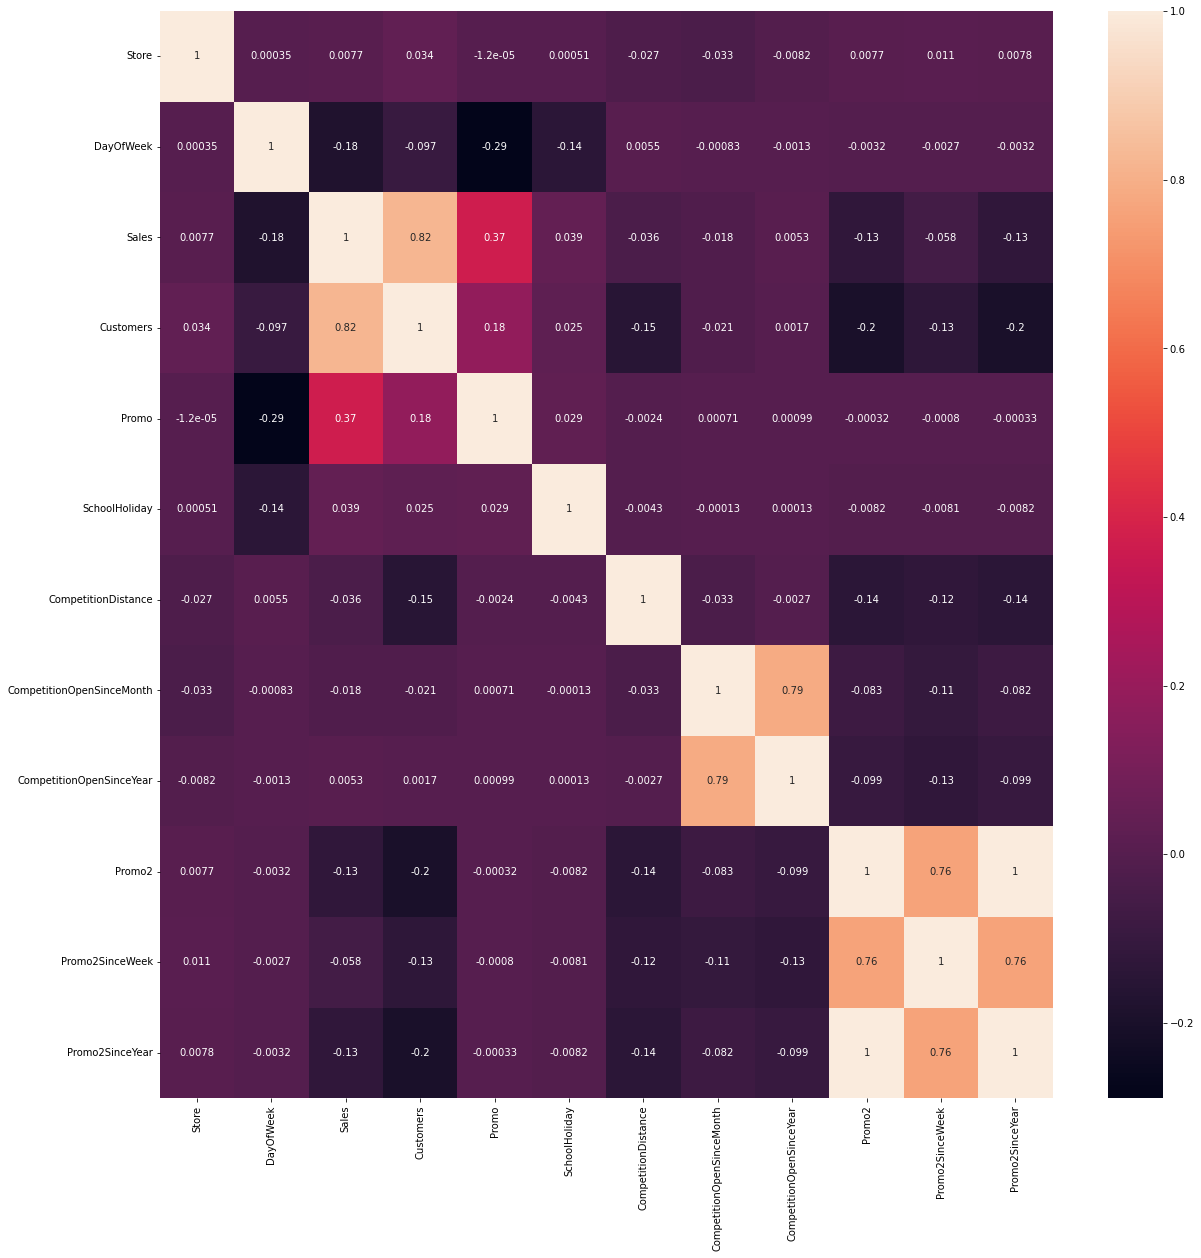

In [41]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)
plt.show()
# Customers/Prmo2 and sales are strongly correlated 

In [42]:
# Let's separate the year and put it into a separate column 
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [43]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013


In [44]:
# Let's do the same for the Day and Month
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [45]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


Text(0.5, 1.0, 'Average Customers Per Month')

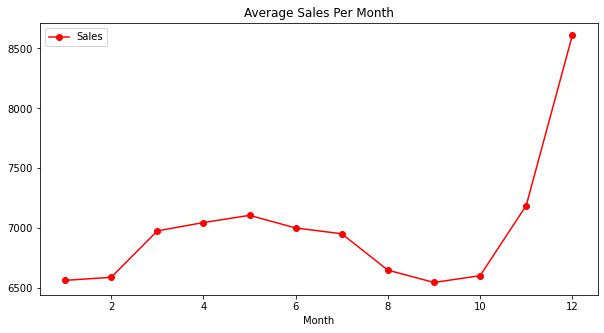

<Figure size 432x288 with 0 Axes>

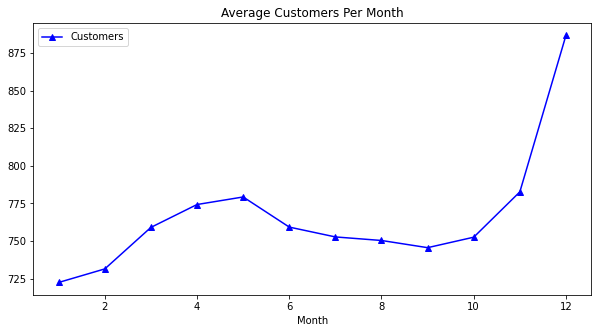

In [46]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column  
# It looks like sales and number of customers peak around christmas timeframe
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure()
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month')


Text(0.5, 1.0, 'Average Sales Per Day')

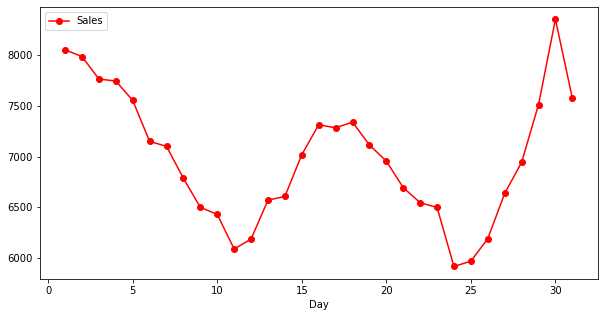

<Figure size 432x288 with 0 Axes>

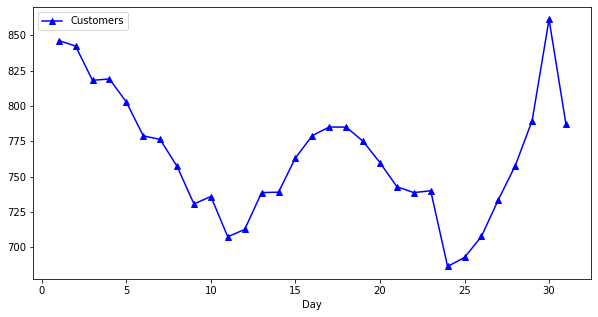

In [47]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month
ax = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure()
ax = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Sales Per Day')


Text(0.5, 1.0, 'Average Customers Per Day of the Week')

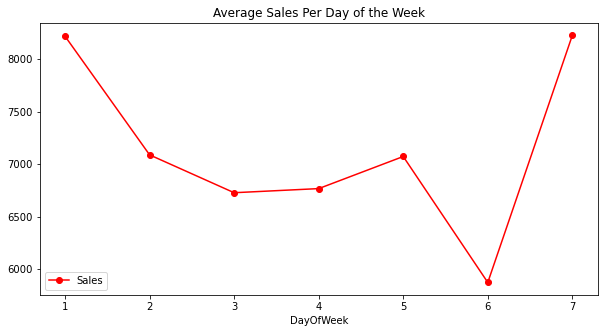

<Figure size 432x288 with 0 Axes>

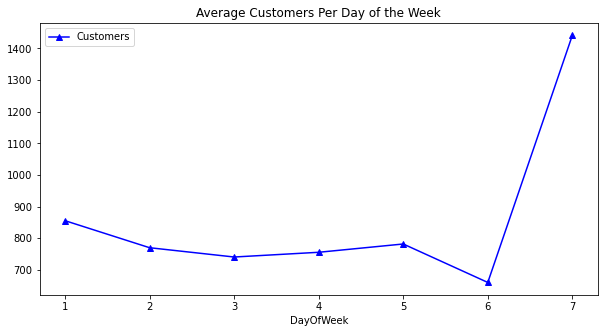

In [48]:
# Let's do the same for the day of the week  (note that 7 = Sunday)

axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')


<AxesSubplot:xlabel='Date'>

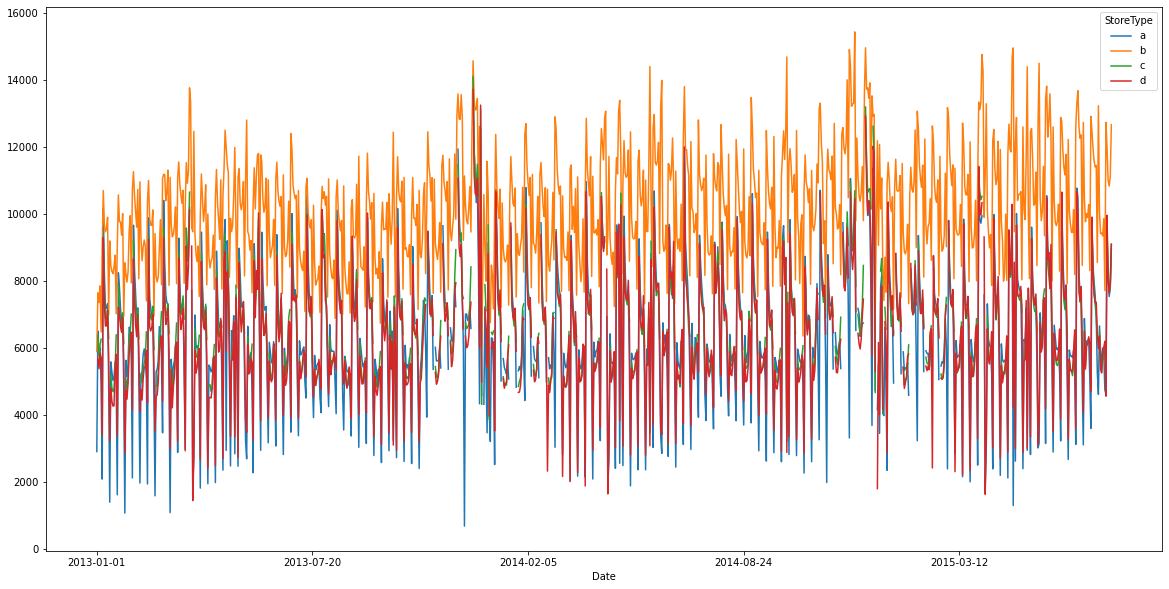

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Date','StoreType']).mean()['Sales'].unstack().plot(ax=ax)

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

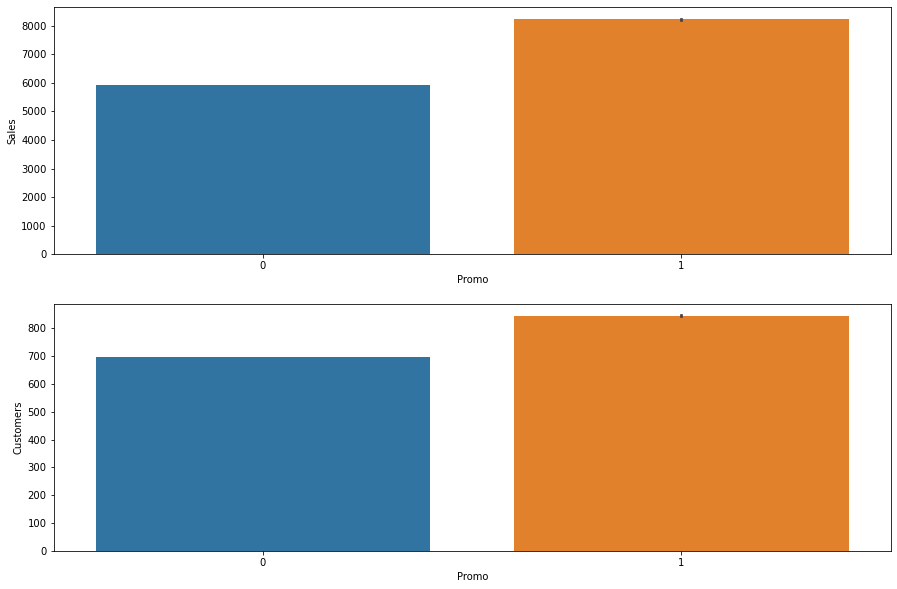

In [50]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

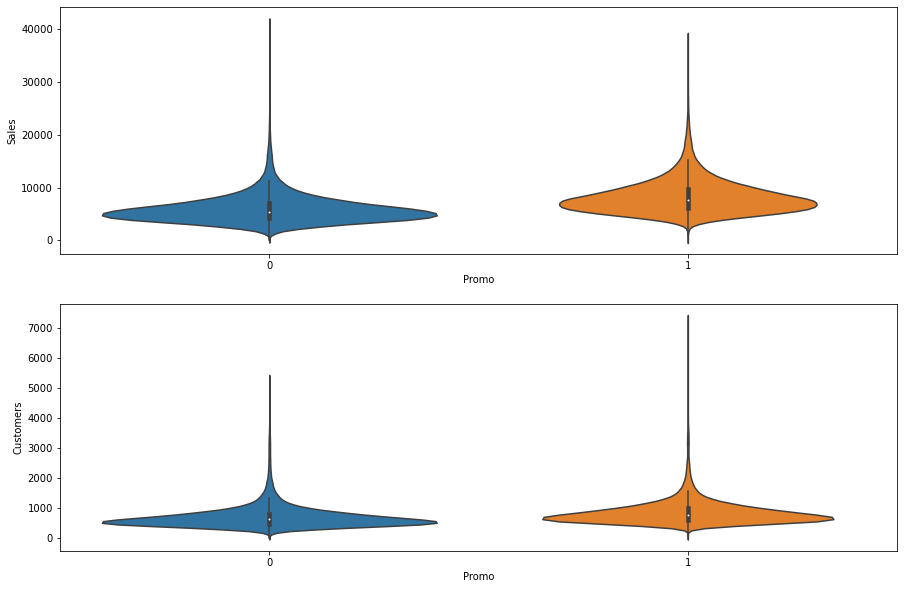

In [51]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.violinplot(x = 'Promo', y = 'Sales', data = sales_train_all_df)

plt.subplot(212)
sns.violinplot(x = 'Promo', y = 'Customers', data = sales_train_all_df)

# Sales Modeling Using Facebooks Prophet Package

### Let´s start with a simple model

In [52]:
from fbprophet import Prophet

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [53]:
def sales_prediction(Store_ID, sales_df, periods):
  # Function that takes in the data frame, storeID, and number of future period forecast
  # The function then generates date/sales columns in Prophet format
  # The function then makes time series predictions

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet()
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


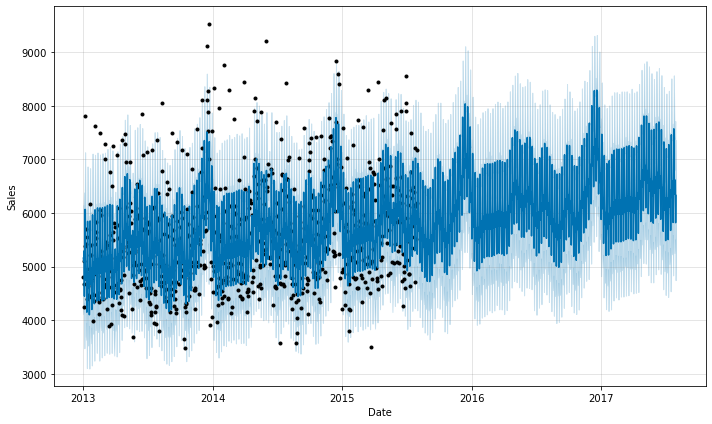

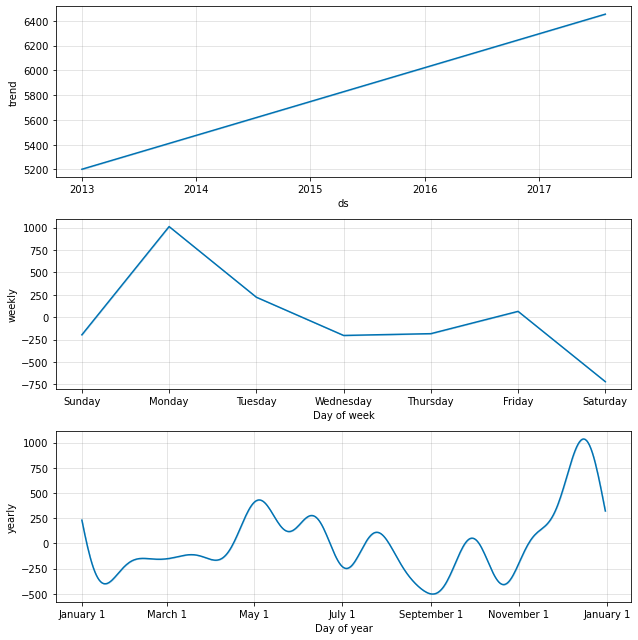

In [54]:
model = sales_prediction(10, sales_train_all_df, 365*2)

### Add Features

In [55]:
Store_ID = 10
periods = 180
sales_df = sales_train_all_df[sales_train_all_df['Store'] == Store_ID ]
sales_df = sales_df.rename(columns = {'Date': 'ds', 'Sales':'y'})
sales_df = sales_df.sort_values('ds')
sales_df.head()

,Store,DayOfWeek,ds,y,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
7819,10,3,2013-01-02,4812,521,0,0,1,a,a,3160.0,9.0,2009.0,0,0.0,0.0,0,2013,1,2
7818,10,4,2013-01-03,4675,491,0,0,1,a,a,3160.0,9.0,2009.0,0,0.0,0.0,0,2013,1,3
7817,10,5,2013-01-04,5114,517,0,0,1,a,a,3160.0,9.0,2009.0,0,0.0,0.0,0,2013,1,4
7816,10,6,2013-01-05,4256,489,0,0,0,a,a,3160.0,9.0,2009.0,0,0.0,0.0,0,2013,1,5
7815,10,1,2013-01-07,7804,751,1,0,0,a,a,3160.0,9.0,2009.0,0,0.0,0.0,0,2013,1,7


In [56]:
# train-test split
cutoff_day = 365*1
sales_df_train = sales_df[:cutoff_day]
sales_df_test = sales_df[cutoff_day:]

In [57]:
# init model
model = Prophet()
# add regressors
model.add_regressor('Customers')
model.add_regressor('Promo')
# fit on training data
model.fit(sales_df_train)
# forecast on train/test data
forecast = model.predict(sales_df)
forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Customers,Customers_lower,Customers_upper,Promo,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5091.996219,3927.077000,4687.003340,5091.996219,5091.996219,-678.865449,-678.865449,-678.865449,0.000000,...,-678.865449,-678.865449,-678.865449,-125.254832,-125.254832,-125.254832,0.0,0.0,0.0,4287.875938
1,2013-01-03,5090.695484,3624.385821,4382.114208,5090.695484,5090.695484,-984.409313,-984.409313,-984.409313,0.000000,...,-984.409313,-984.409313,-984.409313,-100.523537,-100.523537,-100.523537,0.0,0.0,0.0,4005.762634
2,2013-01-04,5089.394750,3940.042800,4687.312843,5089.394750,5089.394750,-719.604631,-719.604631,-719.604631,0.000000,...,-719.604631,-719.604631,-719.604631,-50.420659,-50.420659,-50.420659,0.0,0.0,0.0,4319.369460
3,2013-01-05,5088.094015,4072.274973,4797.932900,5088.094015,5088.094015,-1004.778904,-1004.778904,-1004.778904,0.000000,...,-1004.778904,-1004.778904,-1004.778904,323.533539,323.533539,323.533539,0.0,0.0,0.0,4406.848651
4,2013-01-07,5085.492547,6926.351324,7680.237652,5085.492547,5085.492547,1663.637508,1663.637508,1663.637508,484.864601,...,2148.502109,2148.502109,2148.502109,93.464068,93.464068,93.464068,0.0,0.0,0.0,7327.458723


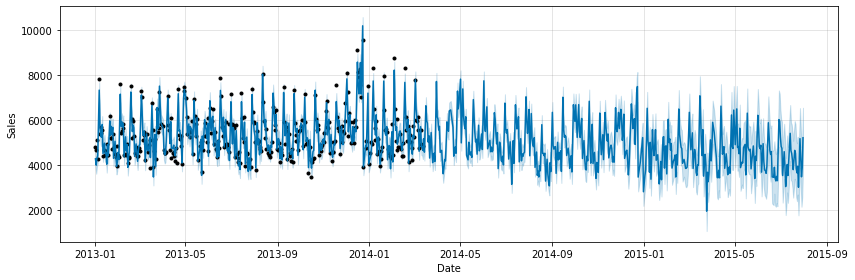

In [58]:
figure   = model.plot(forecast, 
                      xlabel='Date', 
                      ylabel='Sales',
                      figsize=(12,4))

In [59]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Customers', 'Customers_lower', 'Customers_upper', 'Promo',
       'Promo_lower', 'Promo_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

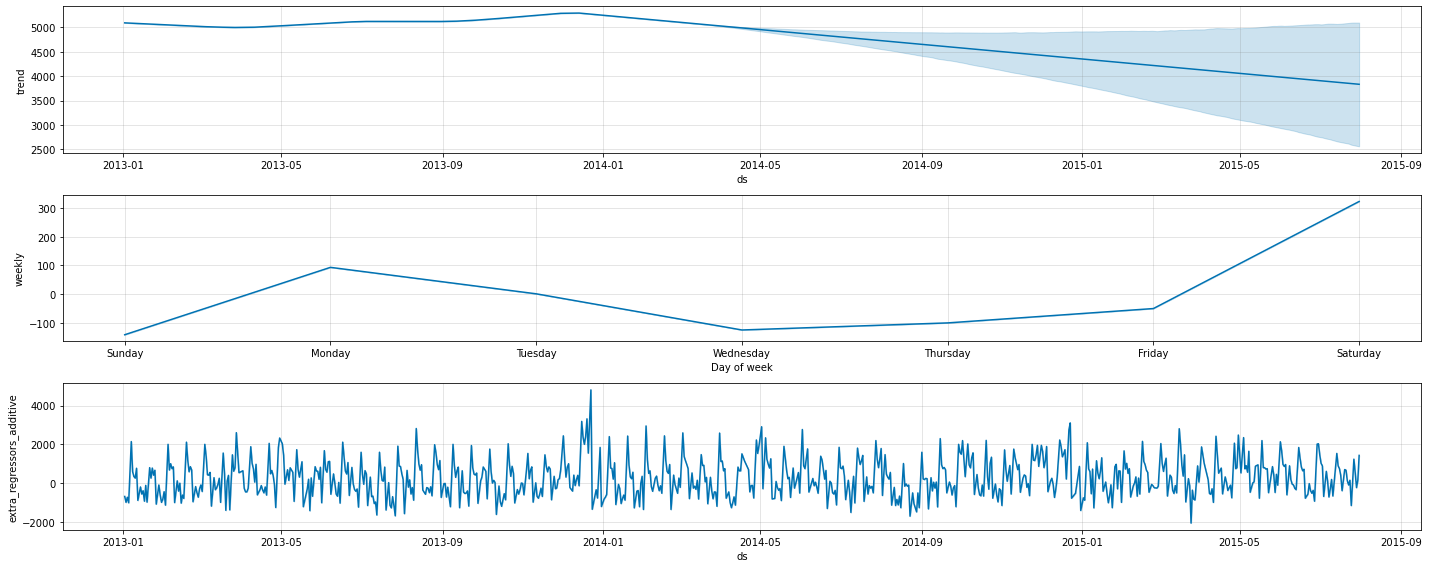

In [60]:
figure2  = model.plot_components(forecast,
                                 figsize=(20,8))

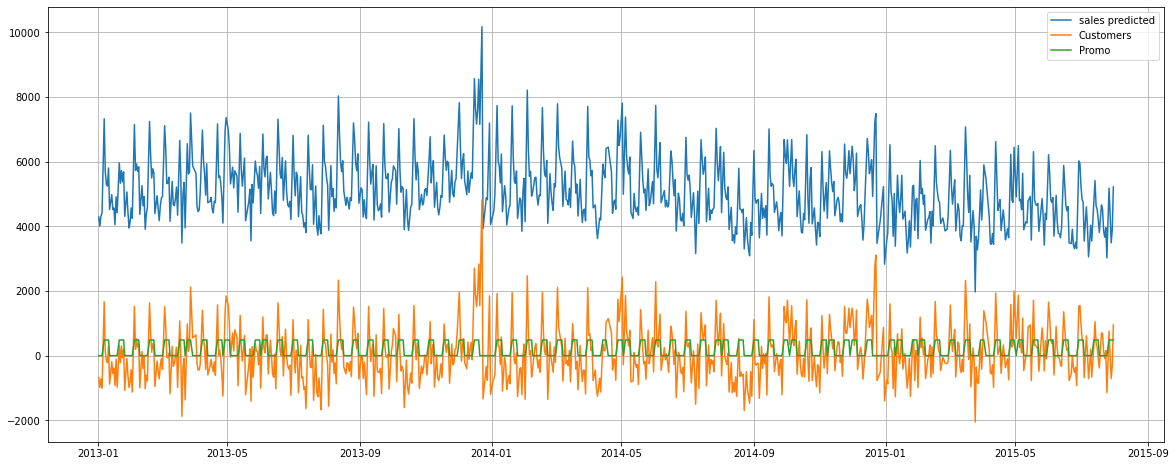

In [61]:
plt.figure(figsize=(20,8))
plt.plot(pd.to_datetime(forecast['ds']), 
         forecast['yhat'])
plt.plot(pd.to_datetime(forecast['ds']), 
         forecast['Customers'])
plt.plot(pd.to_datetime(forecast['ds']), 
         forecast['Promo'])
plt.grid('on')
plt.legend(['sales predicted', 'Customers', 'Promo'])

### Let´s Validate the Model´s Performance Using the Cross-Validation Technique (Adapted for Time Series)

In [161]:
from IPython.display import display

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

from dask.distributed import Client
client = Client(processes=False)

c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61113 instead
  f"Port {expected} is already in use.\n"


Prophet has a built in .cross_validation() function which takes in:
- a model (m)
- the length of time each forecast should cover (horizon)
- how frequently to make forecasts (period)
- the amount of data to train on before making any predictions (initial)

In [171]:
def sales_prediction_validate(Store_ID, sales_df, holidays=None, add_features=None):
  # Function that takes in the data frame, storeID, and number of future period forecast
  # You may wanna pass an array containing hollidays to improve the model
  # You may wanna pass a list with additional features/regressors to improve the model
  # The function then generates date/sales columns in Prophet format
  # The function then makes time series predictions

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df.rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model = Prophet(holidays=holidays)
  # add features
  if add_features != None:
    for feat in add_features:
      model.add_regressor(feat)
  # fit model  
  model.fit(sales_df)

  df_cv = cross_validation(model, 
                           initial='365 days', 
                           period='90 days', 
                           horizon='365 days',
                           parallel='dask')
  pm = performance_metrics(df_cv, rolling_window=0.1)
  display(pm.head(), pm.tail())
  fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=.1)
  plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-02-01 00:00:00 and 2014-07-31 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'inproc://192.168.178.32/832/1' processes=1 threads=16, memory=31.95 GiB>


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,115511.930340,339.870461,263.380654,0.048056,0.041974,0.714286
1,37 days,115304.517162,339.565188,262.053926,0.047848,0.041974,0.714286
2,38 days,113038.425688,336.211876,257.943862,0.047327,0.041555,0.719780
3,39 days,111677.419895,334.181717,256.320323,0.047326,0.041974,0.725275
4,40 days,108686.728410,329.676703,249.808638,0.046240,0.041555,0.736264


,horizon,mse,rmse,mae,mape,mdape,coverage
325,361 days,153466.941221,391.748569,312.118247,0.056935,0.041424,0.664835
326,362 days,154641.001741,393.244201,313.208972,0.057037,0.044795,0.648352
327,363 days,142498.251726,377.489406,299.831848,0.053776,0.041424,0.670330
328,364 days,143954.283997,379.413078,302.364112,0.054065,0.041424,0.670330
329,365 days,143302.790641,378.553551,301.379873,0.053503,0.039304,0.670330


c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\fbprophet\plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\fbprophet\plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


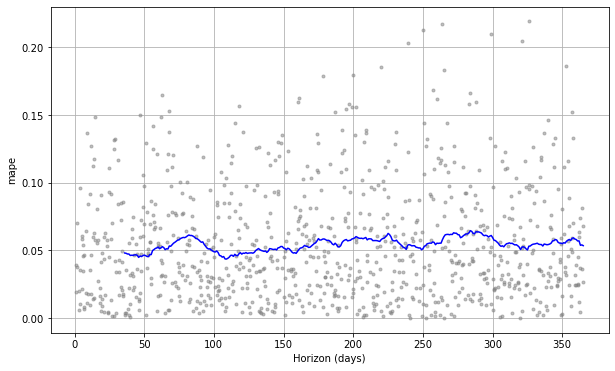

In [172]:
# lets validate the simple model
sales_prediction_validate(10, sales_train_all_df, add_features=['Customers', 'Promo'])

## Let´s include holidays to improve model accuracy


   - StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
   - SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
  






In [173]:
def sales_prediction(Store_ID, sales_df, holidays, periods):
  # Function that takes in the storeID and returns two date/sales columns in Prophet format
  # Format data to fit prophet 

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df.rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

In [174]:
# Get all the dates pertaining to school holidays 
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [175]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [176]:
# Get all the dates pertaining to state holidays 
state_holidays = sales_train_all_df [ (sales_train_all_df['StateHoliday'] == 'a') | (sales_train_all_df['StateHoliday'] == 'b') | (sales_train_all_df['StateHoliday'] == 'c')  ].loc[:, 'Date'].values
state_holidays.shape

(910,)

In [177]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

In [178]:
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [179]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

In [180]:
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [181]:
# concatenate both school and state holidays 
school_state_holidays = pd.concat((state_holidays, school_holidays))

In [182]:
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


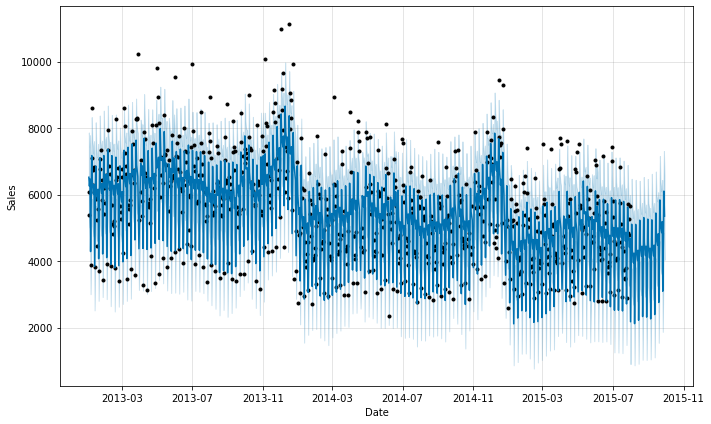

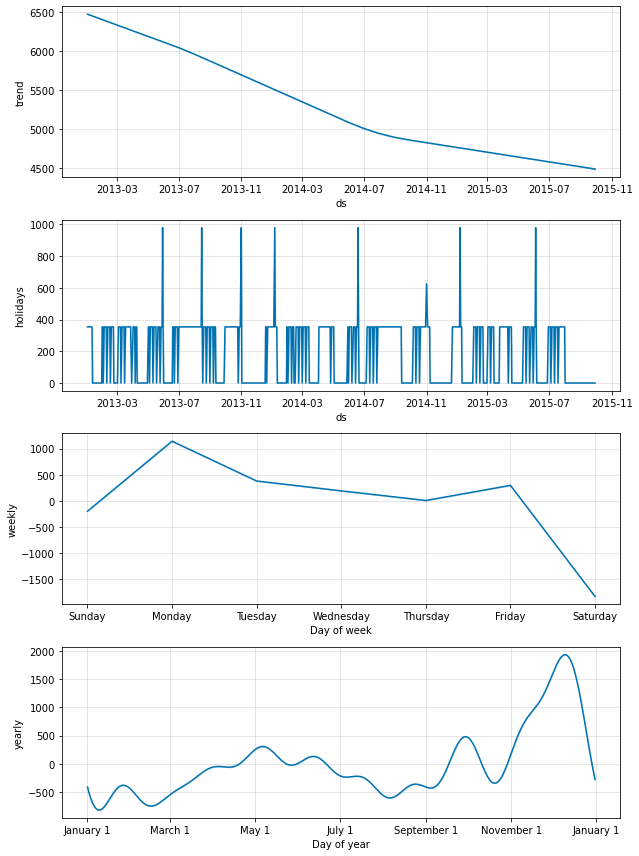

In [183]:
# Let's make predictions using holidays for a specific store
sales_prediction(6, sales_train_all_df, school_state_holidays, 60)

### Let´s validate this extended model and compare to the simple model above

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2014-02-01 00:00:00 and 2014-07-31 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'inproc://192.168.178.32/832/1' processes=1 threads=16, memory=31.95 GiB>


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,113636.180330,337.099659,258.728216,0.047194,0.041941,0.736264
1,37 days,113447.455759,336.819619,257.596638,0.047029,0.041941,0.736264
2,38 days,111193.249311,333.456518,253.624757,0.046538,0.041136,0.741758
3,39 days,109996.916788,331.657831,252.402507,0.046608,0.041941,0.747253
4,40 days,107034.022683,327.160546,246.383908,0.045628,0.041136,0.758242


,horizon,mse,rmse,mae,mape,mdape,coverage
325,361 days,155220.857046,393.980783,315.346259,0.057615,0.041504,0.664835
326,362 days,156209.438954,395.233398,316.288683,0.057691,0.043762,0.648352
327,363 days,143908.694152,379.352994,302.605196,0.054377,0.041504,0.670330
328,364 days,145278.456549,381.154111,304.760433,0.054563,0.041504,0.670330
329,365 days,144555.921985,380.205105,303.756995,0.053994,0.040780,0.670330


c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\fbprophet\plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
c:\Users\Nutzer\.conda\envs\ts_env\lib\site-packages\fbprophet\plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


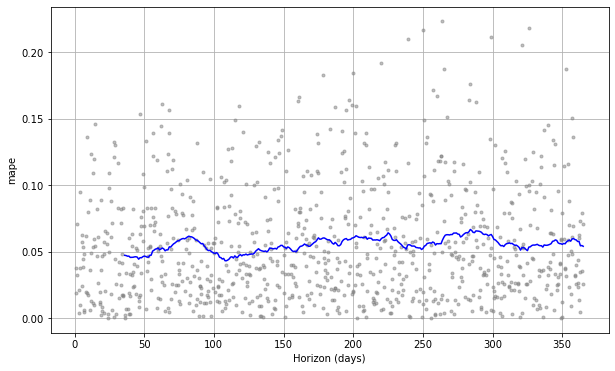

In [184]:
# lets validate 
sales_prediction_validate(10, 
                          sales_train_all_df, 
                          holidays=school_state_holidays, 
                          add_features=['Customers', 'Promo'])